# Try to fix patchiness of Mn output fields

2002 

June, 2019

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import datetime
from pylab import *
import matplotlib
import warnings
import pickle
warnings.filterwarnings("ignore")

%matplotlib notebook

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
#base = '/data/brogalla/run_storage/riv_base-2002_2019-06-03T200733.693872-0400/'
fix  = '/data/brogalla/run_storage/riv_base_2019-06-07T150256.762167-0400/' #mn-patch-ice_2019-06-03T201121.042931-0400/'
monthly_diff = 'ANHA12_EXH006_2002_monthly_diff.nc'
monthly_ave  = 'ANHA12_EXH006_2002_monthly.nc'

Check fday files:

In [10]:
fday = 'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021222-20021226.nc'
# base_fday = nc.Dataset(base+fday)
fix_fday  = nc.Dataset(fix+fday)

# dmn_base = np.array(base_fday.variables['dissolmn'])
# omn_base = np.array(base_fday.variables['oxidismn'])
dmn_fix  = np.array(fix_fday.variables['dissolmn'])
omn_fix  = np.array(fix_fday.variables['oxidismn'])

In [8]:
# print(np.amax(dmn_base), np.amin(dmn_base))
# print(np.amax(omn_base), np.amin(omn_base))

In [6]:
diff_dmn = dmn_fix-dmn_base
diff_omn = omn_fix-omn_base

In [7]:
print(np.amax(diff_dmn), np.amin(diff_dmn), np.average(diff_dmn))
print(np.amax(diff_omn), np.amin(diff_omn), np.average(diff_omn))

2.7572725e-08 -3.3052805e-10 3.9344504e-12
9.519398e-11 -2.753663e-08 -3.9742684e-12


In [11]:
print(np.amax(dmn_fix), np.amin(dmn_fix))
print(np.amax(omn_fix), np.amin(omn_fix))

4.654074e-08 0.0
3.783591e-10 0.0


<IPython.core.display.Javascript object>


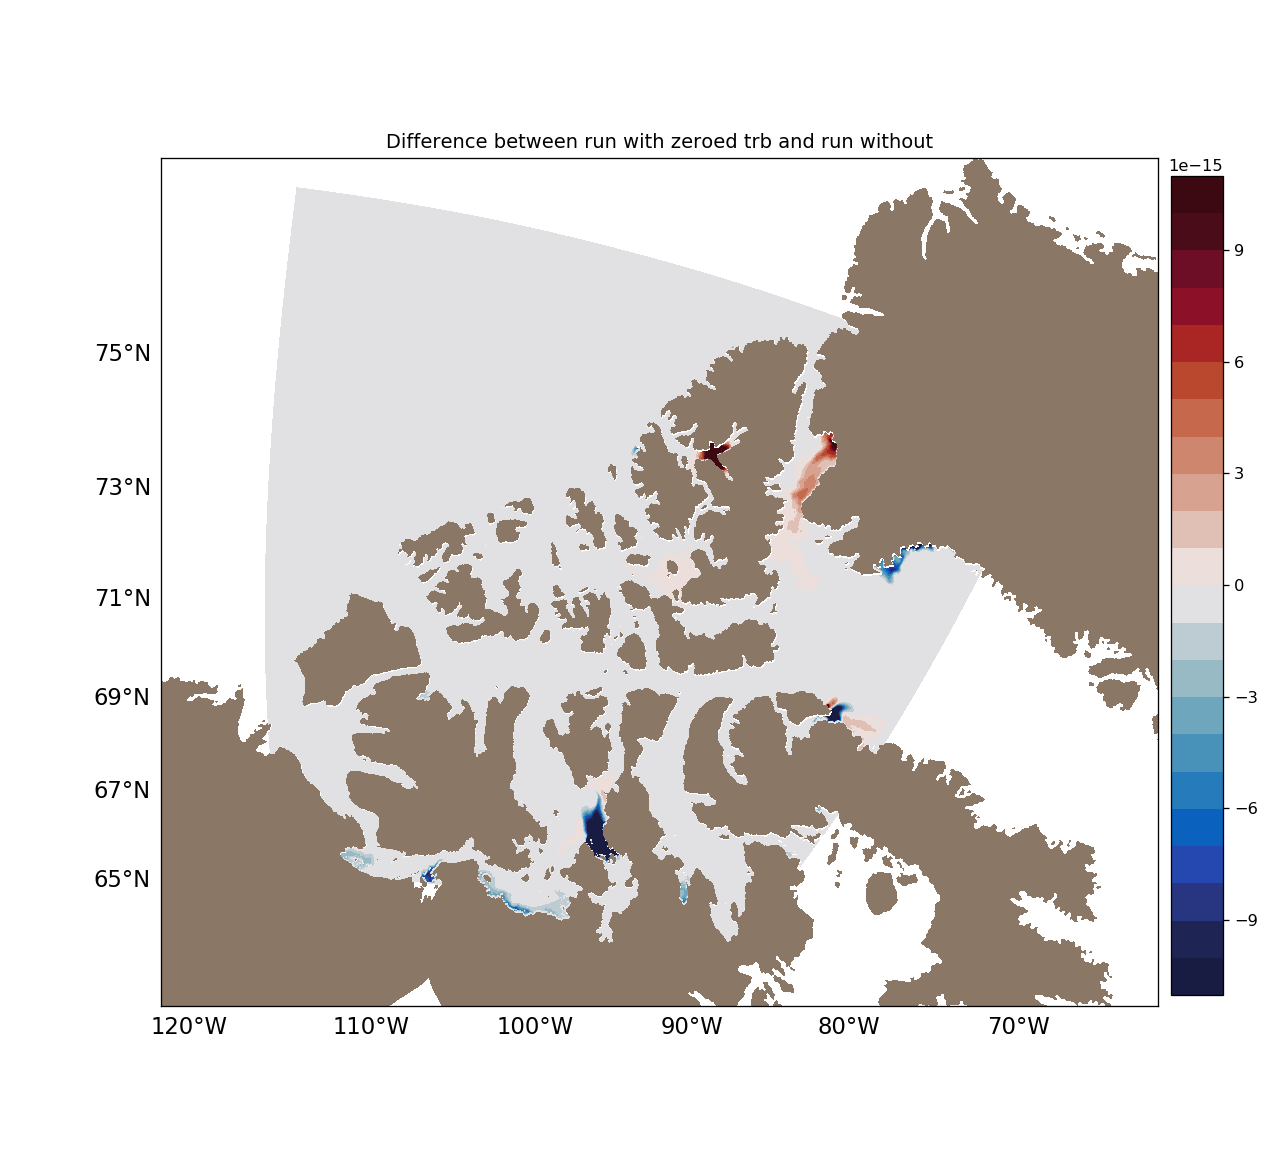

In [26]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)

var = np.ma.masked_where((tmask[0,:,:] < 0.1), diff_dmn[0,0,:,:]) 

clevels=[-6e-12, -1e-14, -9e-15, -8e-15, -7e-15, -6e-15, -5e-15, -4e-15, -3e-15, -2e-15, -1e-15, 0, \
         1e-15, 2e-15, 3e-15, 4e-15, 5e-15, 6e-15, 7e-15, 8e-15, 9e-15, 1e-14, 2e-12]
vmin = -1e-14
vmax = 1e-14
cbar = proj.contourf(x, y, var, clevels, vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, zorder=1)

plt.title('Difference between run with zeroed trb and run without')

fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

Negative values means that the [dMn] was higher before than now, while positive values represent places where the [dMn] is higher than before.

<IPython.core.display.Javascript object>


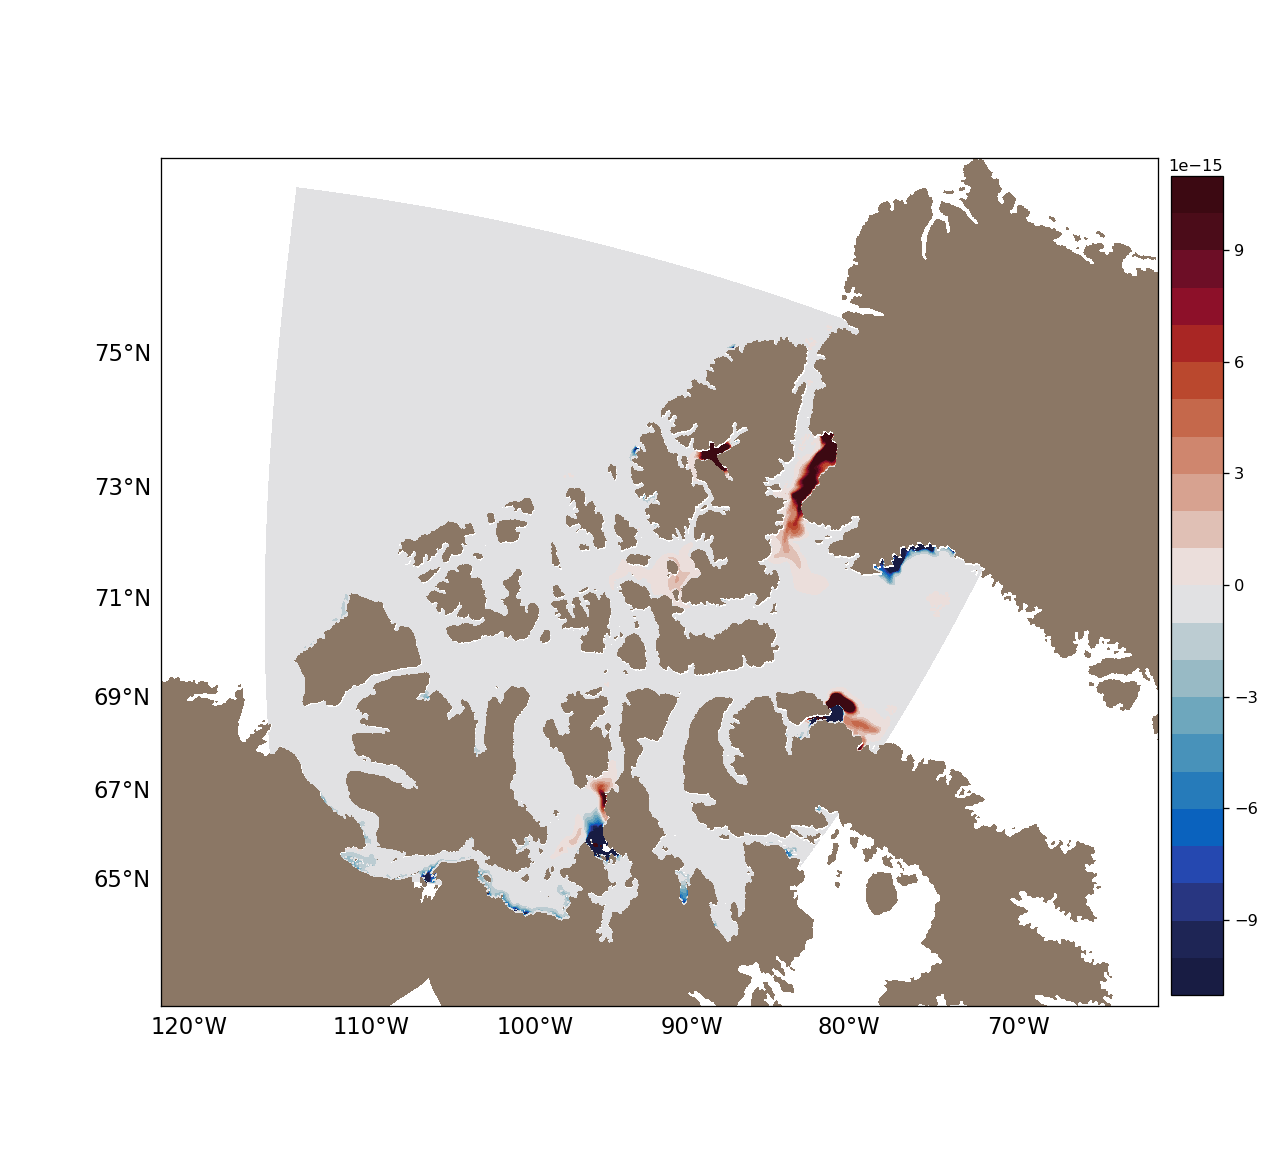

In [111]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)

var = np.ma.masked_where((tmask[0,:,:] < 0.1), diff_omn[0,0,:,:]) 

clevels=[-6e-12, -1e-14, -9e-15, -8e-15, -7e-15, -6e-15, -5e-15, -4e-15, -3e-15, -2e-15, -1e-15, 0, \
         1e-15, 2e-15, 3e-15, 4e-15, 5e-15, 6e-15, 7e-15, 8e-15, 9e-15, 1e-14, 2e-12]
vmin = -1e-14
vmax = 1e-14
cbar = proj.contourf(x, y, var, clevels, vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance, zorder=1)
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

And for oMn (see above) this fixes a number of river locations. Tomorrow check the output from the most recent test run; it has both trb=0 and trn=0 when the concentration of oMn is negative within the scavenging loop.

Mask land values

In [24]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
tmask = tmask[0,:,1480:2050,200:800]
tmask_full_ave     = np.zeros((12, 50, 570, 600))
tmask_full_ave[:]  = tmask
tmask_full_diff    = np.zeros((11, 50, 570, 600))
tmask_full_diff[:] = tmask

In [23]:
def load_monthly(storage, diff=monthly_diff, ave=monthly_ave, \
                 mask_ave=tmask_full_ave, mask_diff=tmask_full_diff):
    
    test_ave  = nc.Dataset(storage+ave)
    test_diff = nc.Dataset(storage+diff)
    
    dmn_ave   = np.array(test_ave.variables['dissolmn'])
    dmn_diff  = np.array(test_diff.variables['dissolmn'])
    
    #apply land mask:
    cond_ave  = (mask_ave  < 0.1) 
    cond_diff = (mask_diff < 0.1)
    dmn_mave  = np.ma.masked_where(cond_ave, dmn_ave[:,0,:,:,:]) 
    dmn_mdiff = np.ma.masked_where(cond_diff, dmn_diff[:,0,:,:,:]) 
    
    return dmn_mave, dmn_mdiff

In [24]:
base_ave, base_diff = load_monthly(base)
fix_ave, fix_diff = load_monthly(fix)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/brogalla/run_storage/test_2019-06-05T125634.378820-0400/ANHA12_EXH006_2002_monthly.nc'

Load the lons, lats, etc.

In [25]:
ref   = nc.Dataset('/data/brogalla/run_storage/mn_test1f/'+monthly_ave)
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

Load map projection

<IPython.core.display.Javascript object>


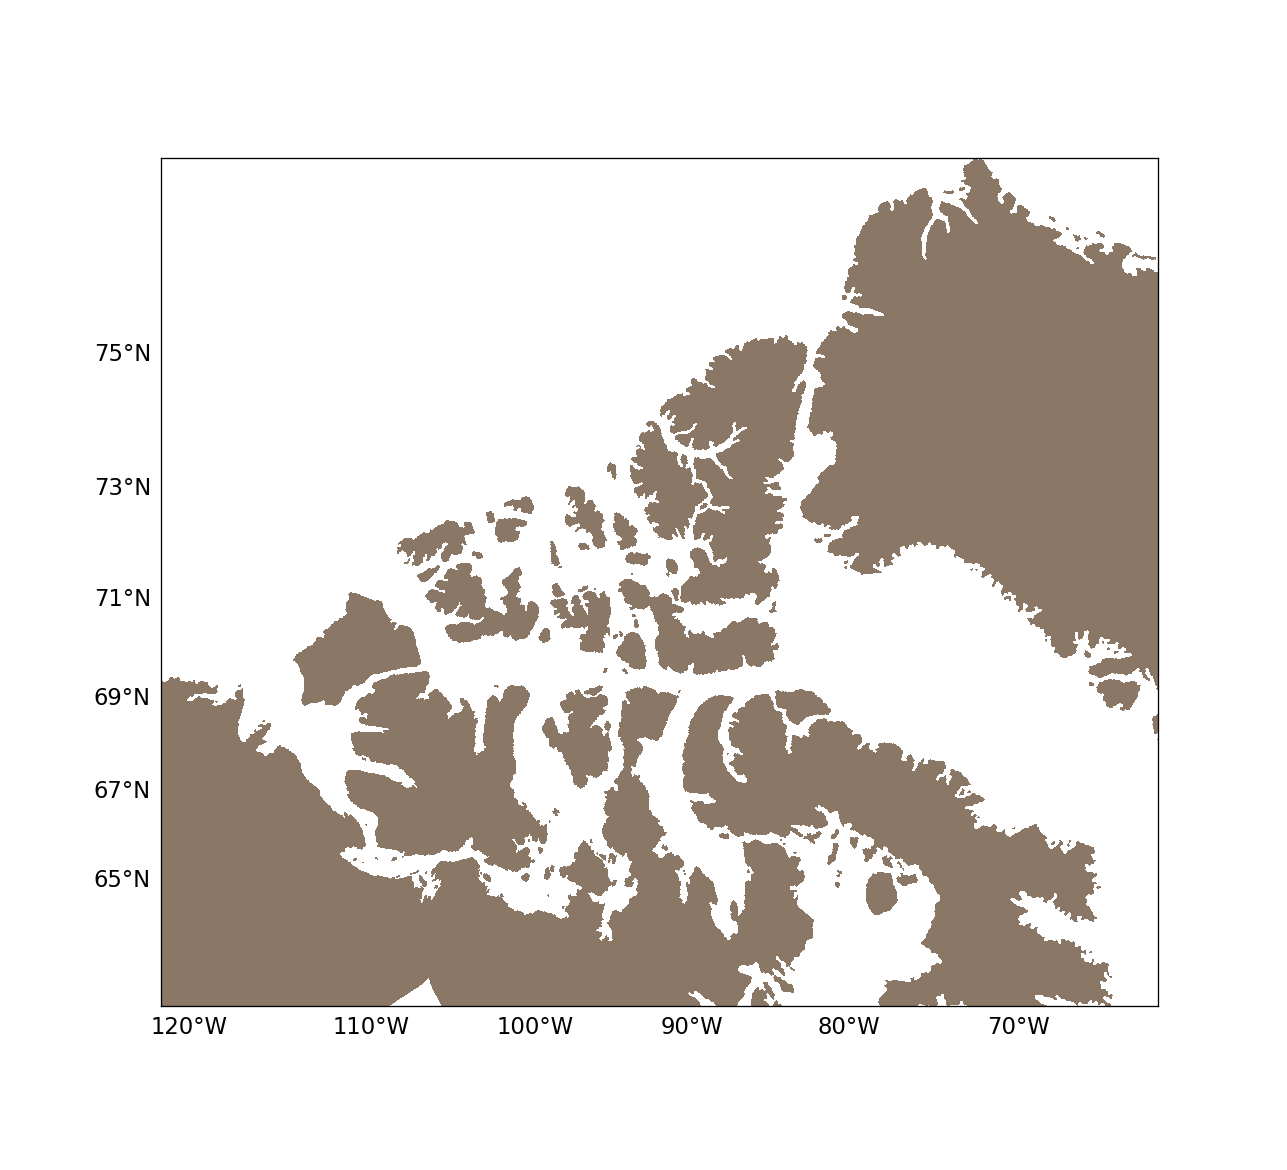

In [120]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

In [121]:
def months_overview(var, title, levels, min_v, max_v, proj=proj):
    ax   = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplotsax.pickle','rb'))
    
    x, y = proj(lons, lats)
    colour=cmocean.cm.rain
    cbar  = proj.contourf(x, y, var[0, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,0])
    proj.contourf(x, y, var[1, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,1])
    proj.contourf(x, y, var[2, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,2])
    proj.contourf(x, y, var[3, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,3])
    proj.contourf(x, y, var[4, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,0])
    proj.contourf(x, y, var[5, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,1])
    proj.contourf(x, y, var[6, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,2])
    proj.contourf(x, y, var[7, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,3])
    proj.contourf(x, y, var[8, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,0])
    proj.contourf(x, y, var[9, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,1])
    proj.contourf(x, y, var[10, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,2])
    proj.contourf(x, y, var[11, 0,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,3])
    
    # figure out how to add to a different set of axes
    #plt.colorbar(jan, ax=ax[0,0])
    
    ax[0,0].set_title('January')
    ax[0,1].set_title('February')
    ax[0,2].set_title('March')
    ax[0,3].set_title('April')
    ax[1,0].set_title('May')
    ax[1,1].set_title('June')
    ax[1,2].set_title('July')
    ax[1,3].set_title('August')
    ax[2,0].set_title('September')
    ax[2,1].set_title('October')
    ax[2,2].set_title('November')
    ax[2,3].set_title('December')
    
    fig = gcf()
    fig.suptitle(title)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
    fig.colorbar(cbar, cax=cbar_ax)

    return

In [122]:
def monthly_changes(var, year, title, levels, min_v, max_v, proj=proj):
    ax   = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplotsax.pickle','rb'))
    
    x, y = proj(lons, lats)
    colour=cmocean.cm.rain
    depth=0
    if year!=0:
        proj.contourf(x, y, var[0+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,0])
    proj.contourf(x, y, var[0+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,1])
    proj.contourf(x, y, var[1+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,2])
    proj.contourf(x, y, var[2+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[0,3])
    proj.contourf(x, y, var[3+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,0])
    proj.contourf(x, y, var[4+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,1])
    proj.contourf(x, y, var[5+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,2])
    cbar = proj.contourf(x, y, var[6+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[1,3])
    proj.contourf(x, y, var[7+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,0])
    proj.contourf(x, y, var[8+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,1])
    proj.contourf(x, y, var[9+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,2])
    proj.contourf(x, y, var[10+year, depth,:,:], levels, vmin=min_v, vmax=max_v, cmap=colour, ax=ax[2,3])
    
    # figure out how to add to a different set of axes
    #plt.colorbar(jan, ax=ax[0,0])
    
    ax[0,0].set_title('January')
    ax[0,1].set_title('February')
    ax[0,2].set_title('March')
    ax[0,3].set_title('April')
    ax[1,0].set_title('May')
    ax[1,1].set_title('June')
    ax[1,2].set_title('July')
    ax[1,3].set_title('August')
    ax[2,0].set_title('September')
    ax[2,1].set_title('October')
    ax[2,2].set_title('November')
    ax[2,3].set_title('December')
    
    fig = gcf()
    fig.suptitle(title)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
    fig.colorbar(cbar, cax=cbar_ax)
    
    return

In [123]:
ave_change  = fix_ave - base_ave 
diff_change = fix_diff - base_diff

In [124]:
print(np.amax(ave_change), np.amin(ave_change), np.average(ave_change))
print(np.amax(diff_change), np.amin(diff_change), np.average(diff_change))

2.2815492e-09 -1.07001075e-11 9.156808183262845e-12
1.8748345e-09 -1.826308e-09 1.495531053459411e-12


<IPython.core.display.Javascript object>


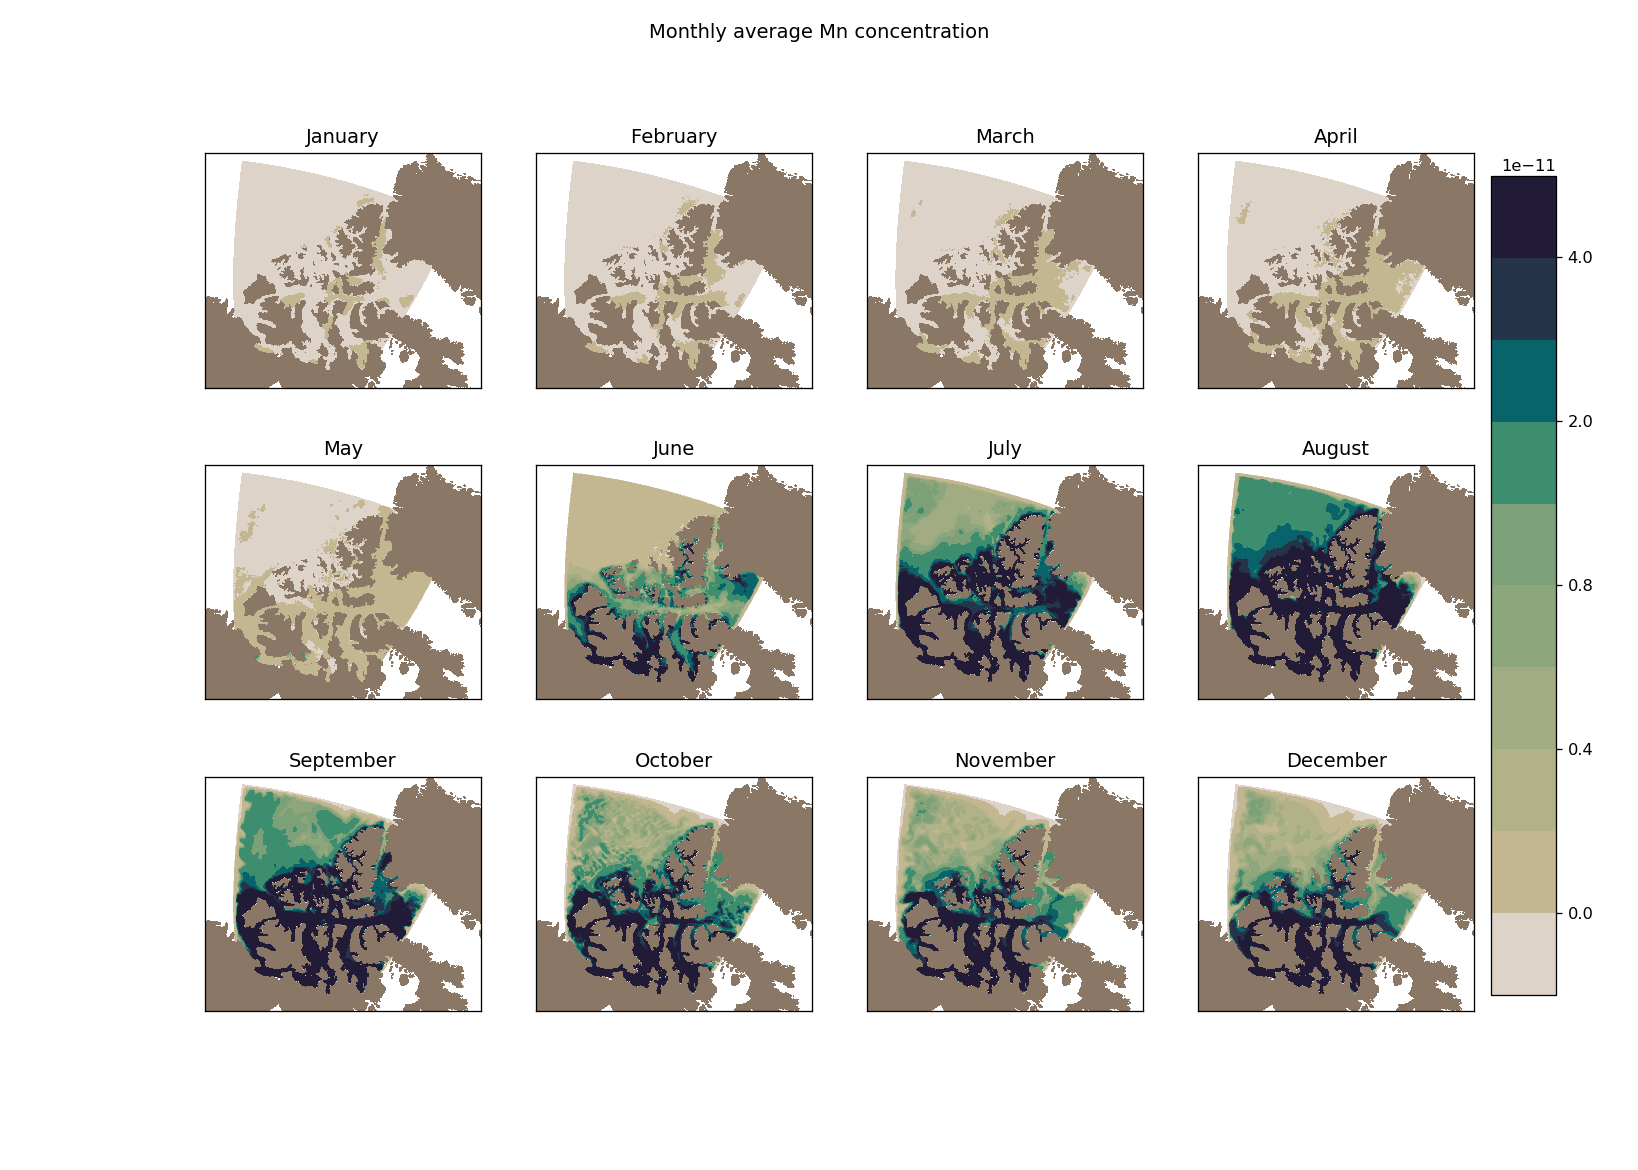

In [125]:
levels_ave = [-1e-11, 0, 2e-12, 4e-12, 6e-12, 8e-12, 1e-11, 2e-11, 3e-11, 4e-11, 2e-9]
vmin  = -1e-11
vmax  = 4e-11
months_overview(ave_change, 'Monthly average Mn concentration', levels_ave, vmin, vmax)

<IPython.core.display.Javascript object>


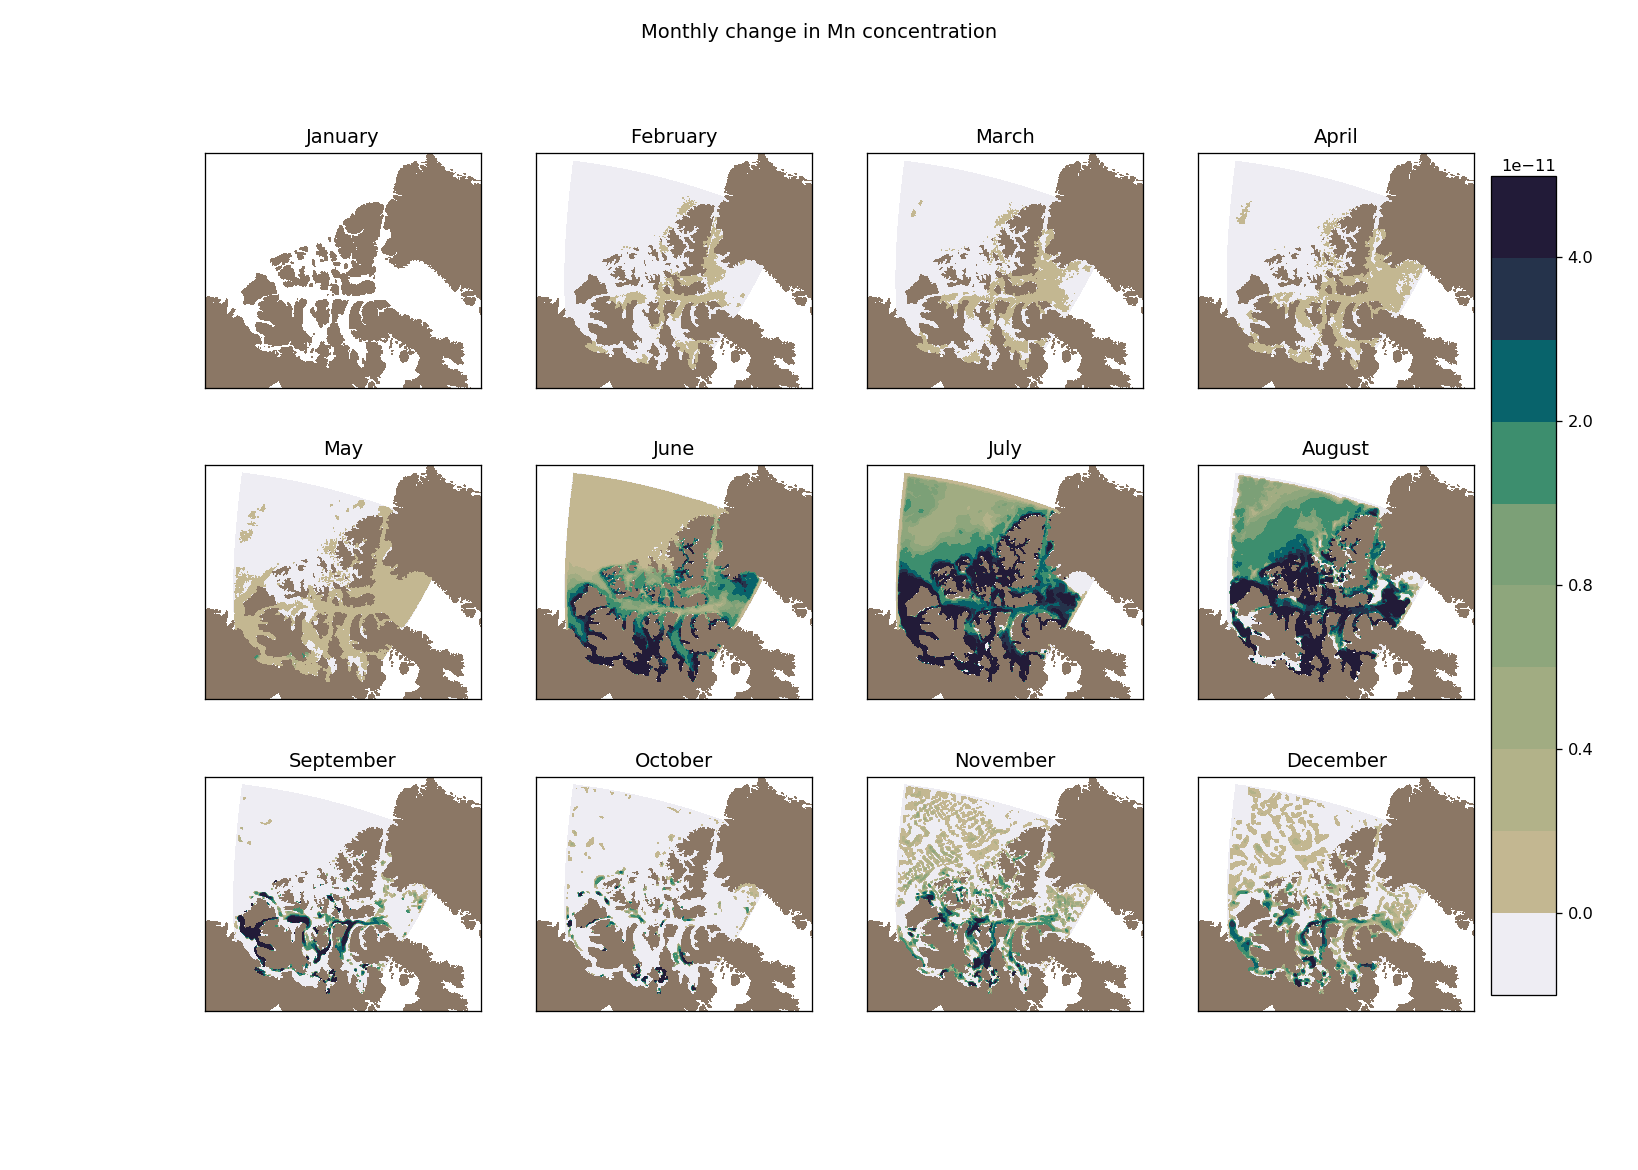

In [126]:
levels_diff = [-1e-9, 0, 2e-12, 4e-12, 6e-12, 8e-12, 1e-11, 2e-11, 3e-11, 4e-11, 2e-9]
vmin  = -1e-11
vmax  = 4e-11
monthly_changes(diff_change, 0, 'Monthly change in Mn concentration', levels_diff, vmin, vmax)

<IPython.core.display.Javascript object>


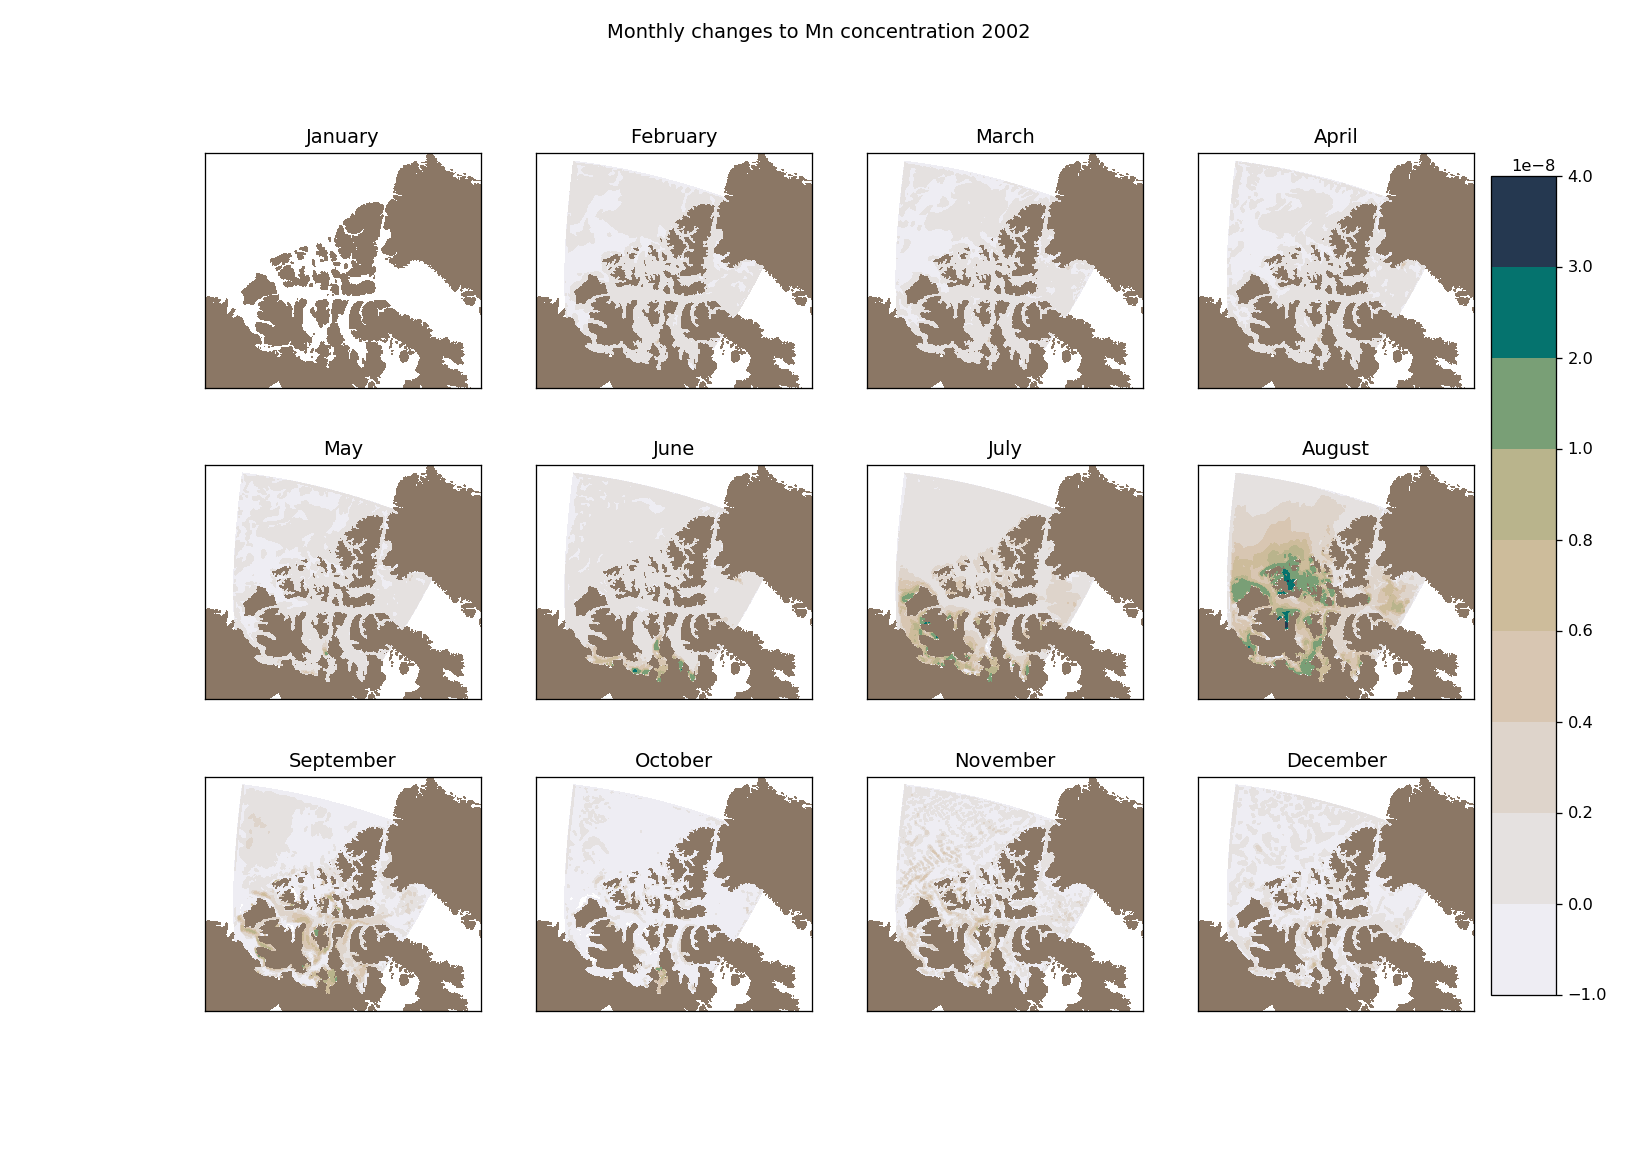

In [127]:
levels_diff = [-1e-8, 0, 2e-9, 4e-9, 6e-9, 8e-9, 1e-8, 2e-8, 3e-8, 4e-8]
vmin  = -1e-9
vmax  = 4e-8
monthly_changes(fix_diff, 0, 'Monthly changes to Mn concentration 2002', levels_diff, vmin, vmax)

### Let's look at the month of November and see if this change has improved it:

Monthly average:

In [128]:
print(np.amax(base_ave), np.amin(base_ave), np.average(base_ave))

4.7494673e-08 0.0 3.4601371363955308e-09


Before:

<IPython.core.display.Javascript object>


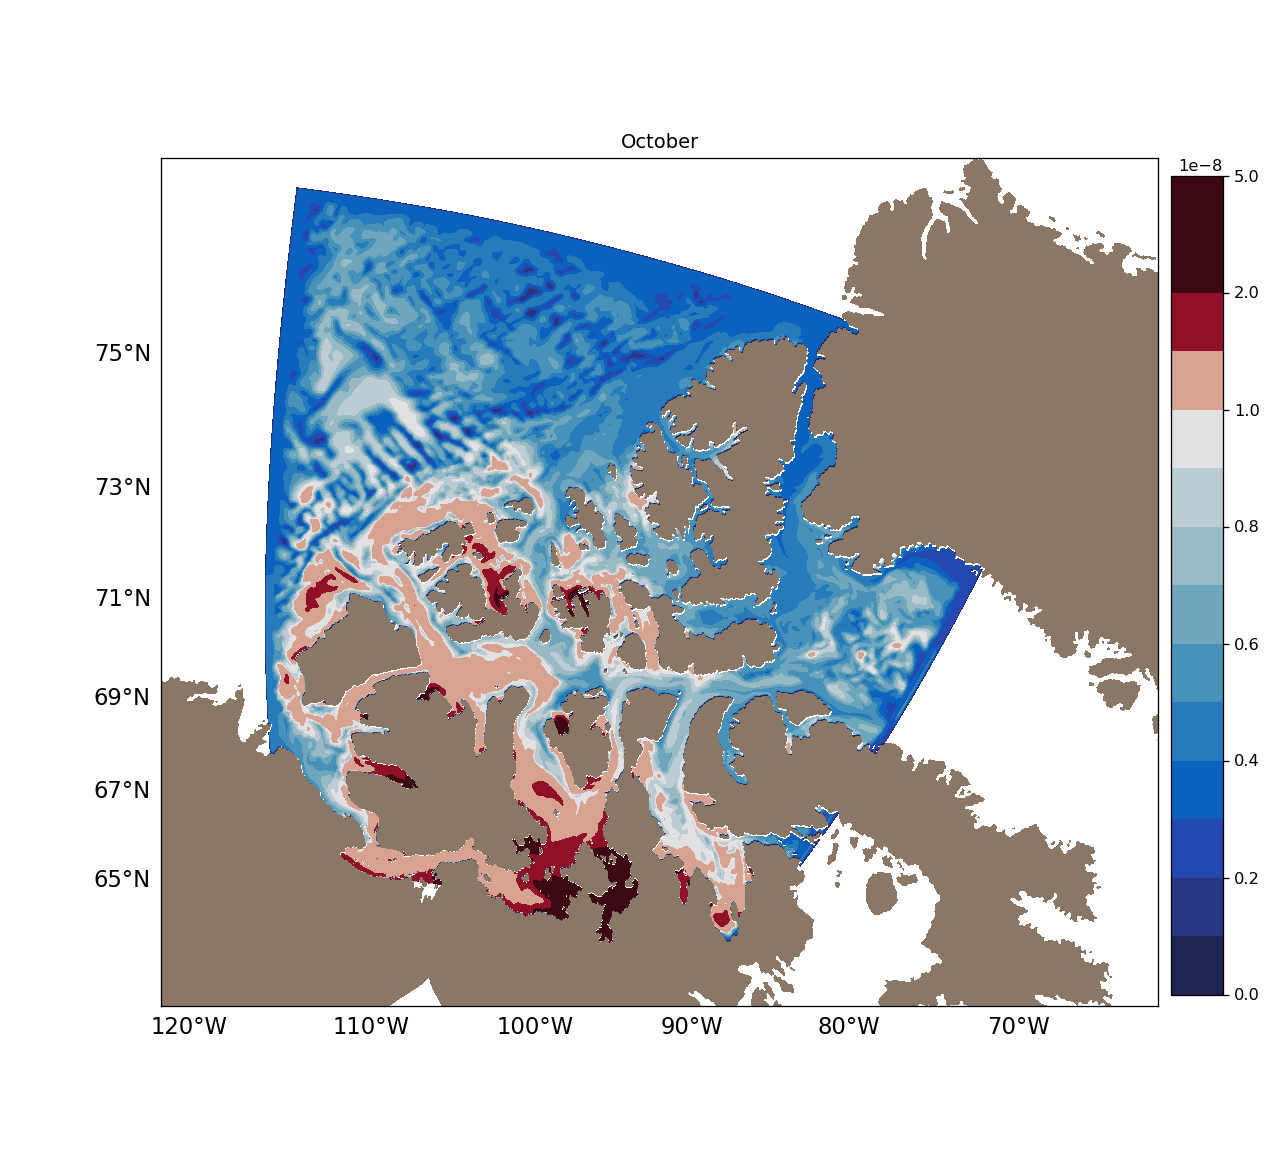

In [129]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)
colour=cmocean.cm.balance

levels_ave = [0, 1e-9, 2e-9, 3e-9, 4e-9, 5e-9, 6e-9, 7e-9, 8e-9, 9e-9, 1e-8, \
              1.5e-8, 2e-8, 2.5e-8, 5e-8]
min_v  = 0
max_v  = 2e-8
cbar = proj.contourf(x, y, base_ave[9,0,:,:], levels_ave, vmin=min_v, vmax=max_v, cmap=colour, )
plt.title('October')
    
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

After:

<IPython.core.display.Javascript object>


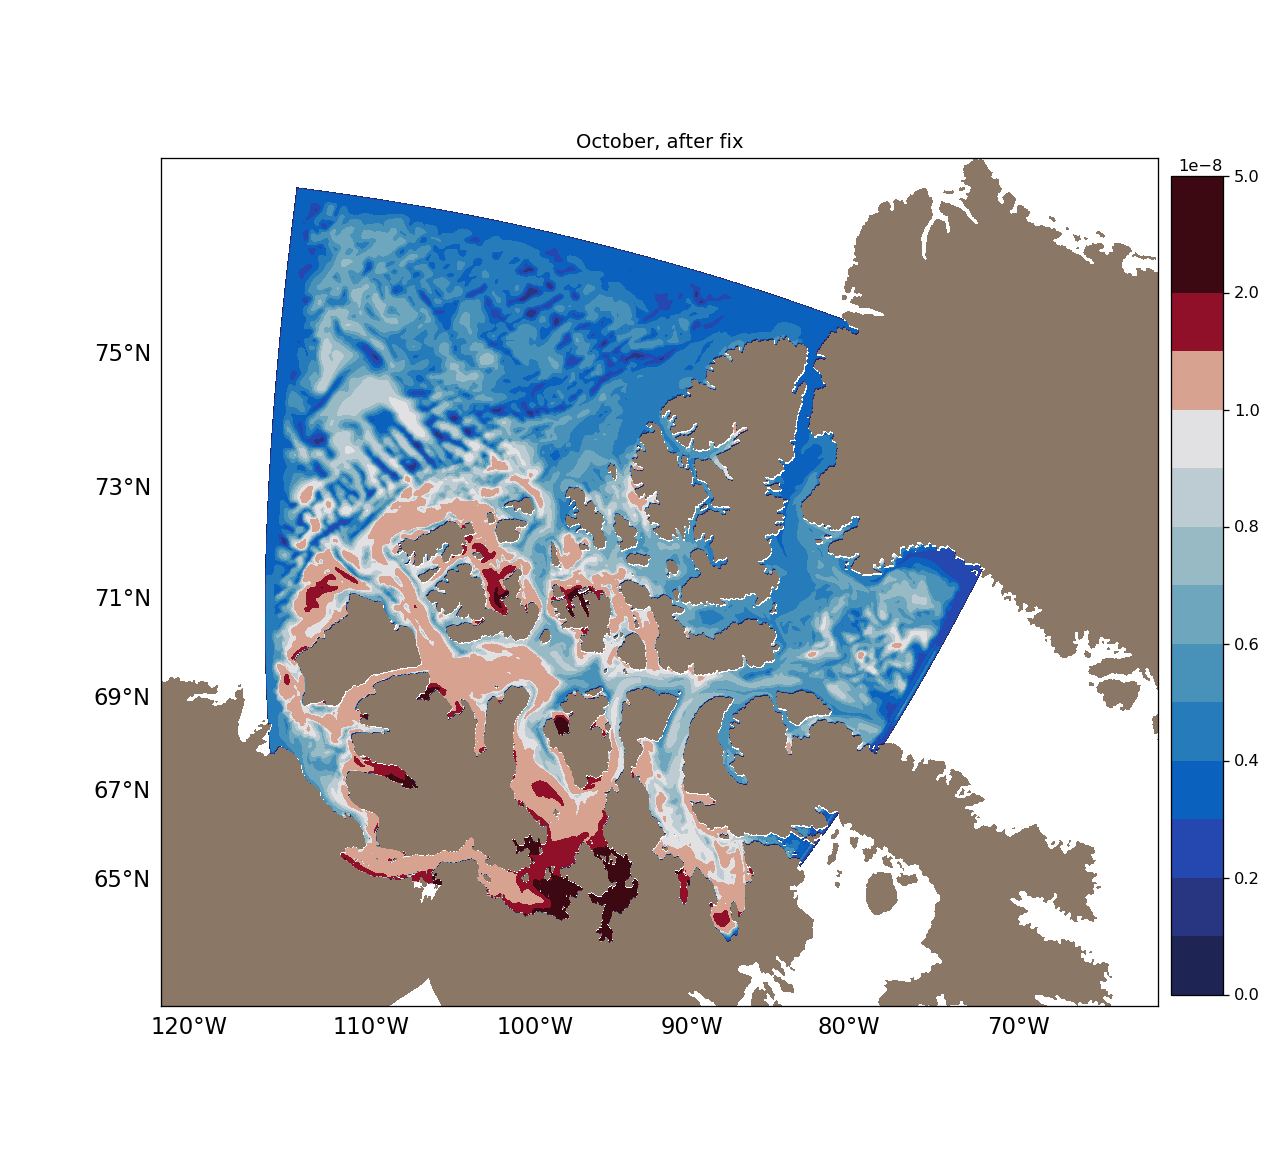

In [130]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)
colour=cmocean.cm.balance

levels_ave = [0, 1e-9, 2e-9, 3e-9, 4e-9, 5e-9, 6e-9, 7e-9, 8e-9, 9e-9, 1e-8, \
              1.5e-8, 2e-8, 2.5e-8, 5e-8]
min_v  = 0
max_v  = 2e-8
cbar = proj.contourf(x, y, fix_ave[9,0,:,:], levels_ave, vmin=min_v, vmax=max_v, cmap=colour, )
plt.title('October, after fix')
    
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

<IPython.core.display.Javascript object>


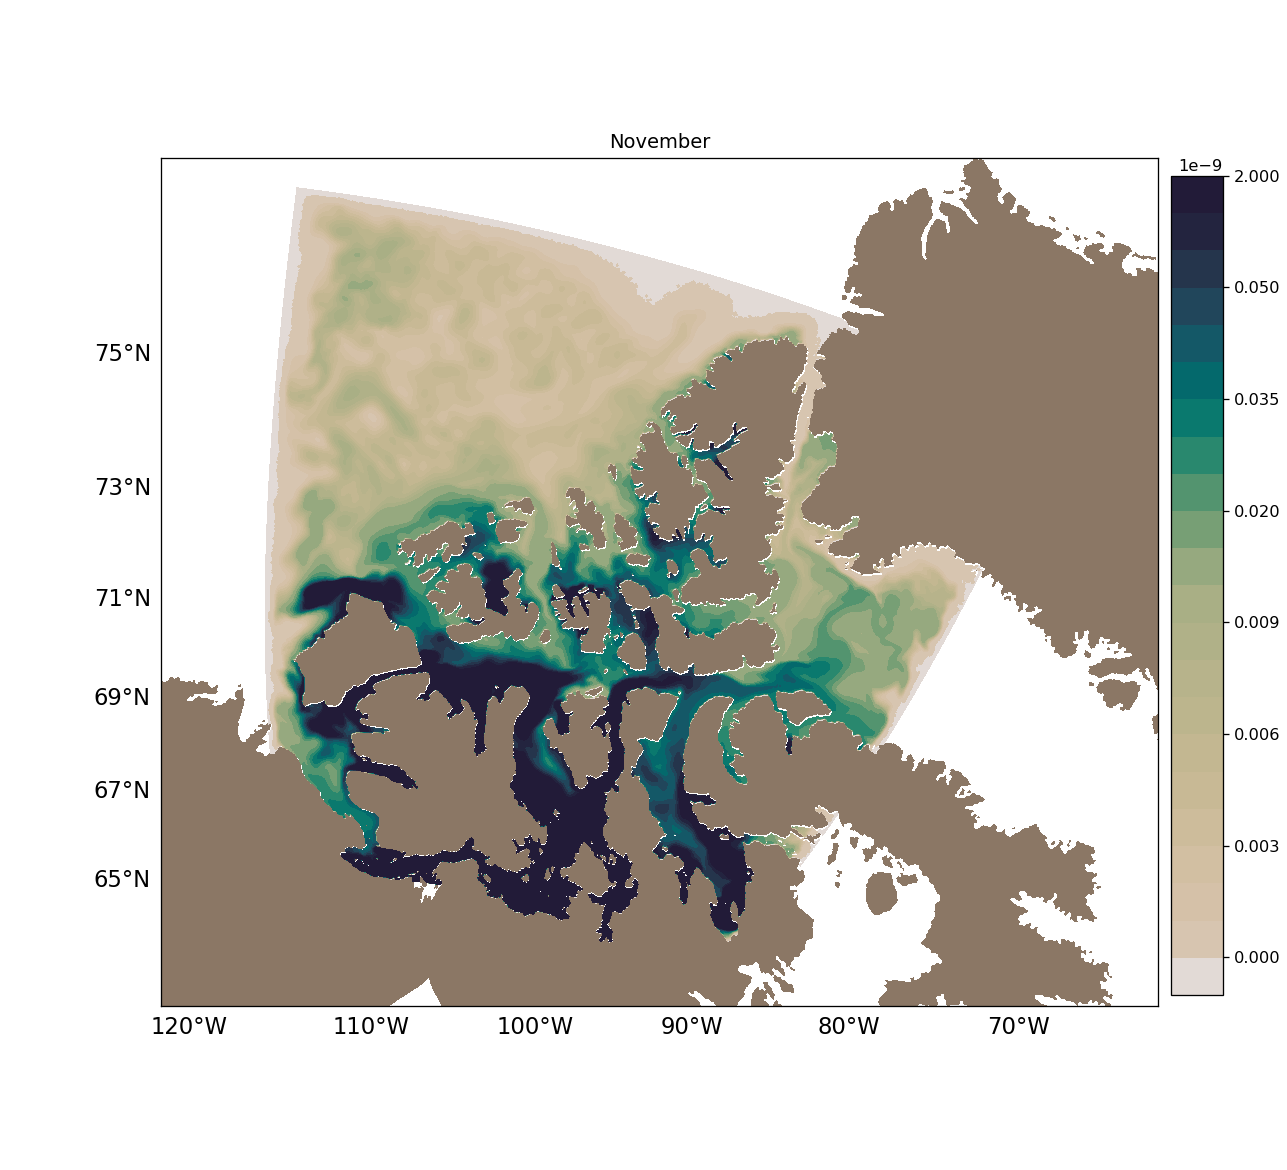

In [131]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)
colour=cmocean.cm.rain

levels_ave = [-1e-11, 0, 1e-12, 2e-12, 3e-12, 4e-12, 5e-12, 6e-12, 7e-12, 8e-12, 9e-12, \
              1e-11, 1.5e-11, 2e-11, 2.5e-11, 3e-11, 3.5e-11, 4e-11, 4.5e-11, 5e-11, 5.5e-11, 6e-11, 2e-9]
min_v  = -1e-11
max_v  = 6e-11
cbar = proj.contourf(x, y, ave_change[10,0,:,:], levels_ave, vmin=min_v, vmax=max_v, cmap=colour, )
plt.title('November')
    
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

Month-to-month change:

In [132]:
print(np.amax(diff_change[10,0,:,:]), np.amin(diff_change[10,0,:,:]), np.average(diff_change[10,0,:,:]))

1.0196821e-10 -2.0036861e-10 -3.639762099880066e-13


Before:

<IPython.core.display.Javascript object>


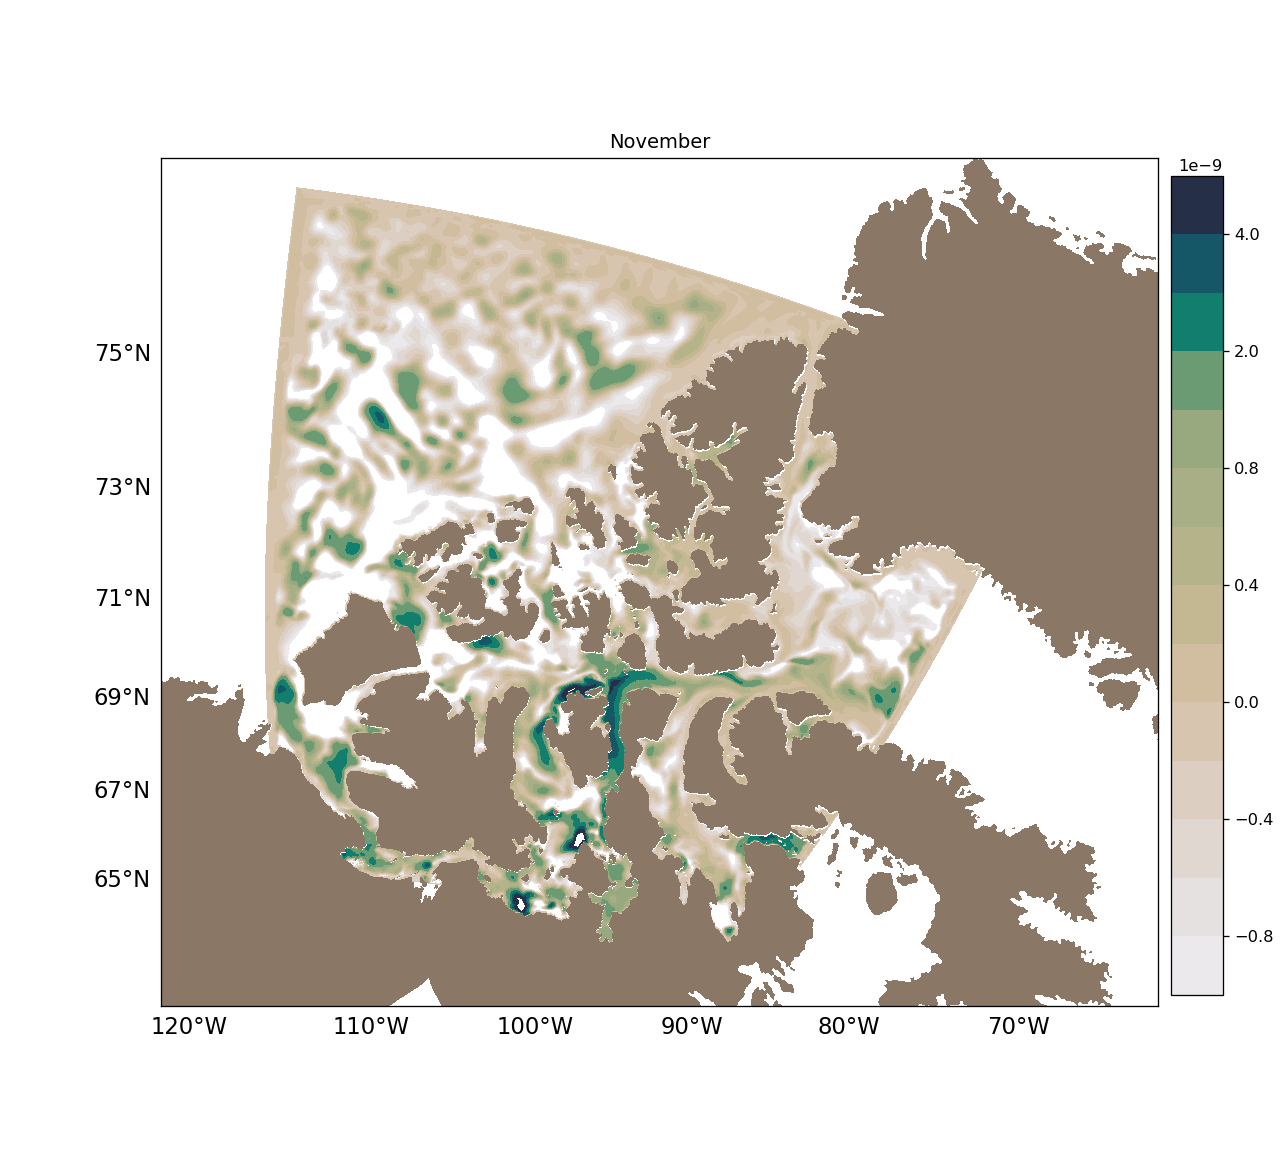

In [133]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)
colour=cmocean.cm.rain

levels_diff = [-1e-9, -8e-10, -6e-10, -4e-10, -2e-10, 0, 2e-10, 4e-10, 6e-10, 8e-10, \
               1e-9, 2e-9, 3e-9, 4e-9, 5e-9]
min_v  = -1e-9
max_v  = 5e-9
cbar = proj.contourf(x, y, base_diff[10,0,:,:], levels_diff, vmin=min_v, vmax=max_v, cmap=colour, )
plt.title('November')
    
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

After:

<IPython.core.display.Javascript object>


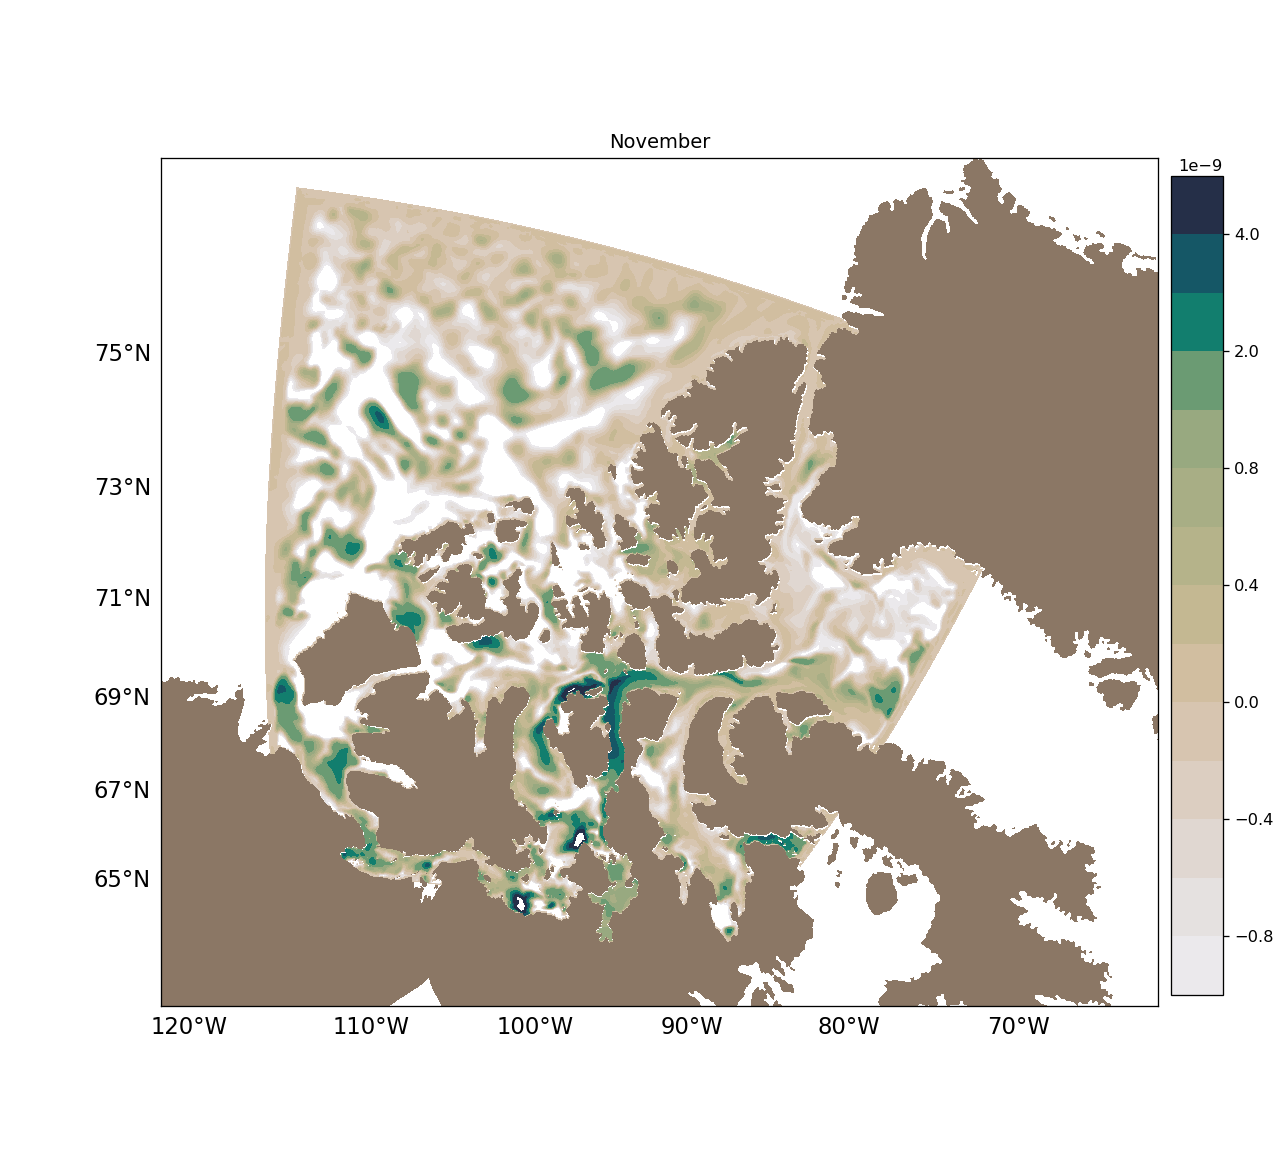

In [16]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)
colour=cmocean.cm.rain

levels_diff = [-1e-9, -8e-10, -6e-10, -4e-10, -2e-10, 0, 2e-10, 4e-10, 6e-10, 8e-10, \
               1e-9, 2e-9, 3e-9, 4e-9, 5e-9]
min_v  = -1e-9
max_v  = 5e-9
cbar = proj.contourf(x, y, fix_diff[10,0,:,:], levels_diff, vmin=min_v, vmax=max_v, cmap=colour, )
plt.title('November')
    
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

Change:

In [20]:
print(np.amax(diff_change[10,0,:,:]), np.amin(diff_change[10,0,:,:]), np.average(diff_change[10,0,:,:]))

1.0196821e-10 -2.0036861e-10 -3.639762099880066e-13


<IPython.core.display.Javascript object>


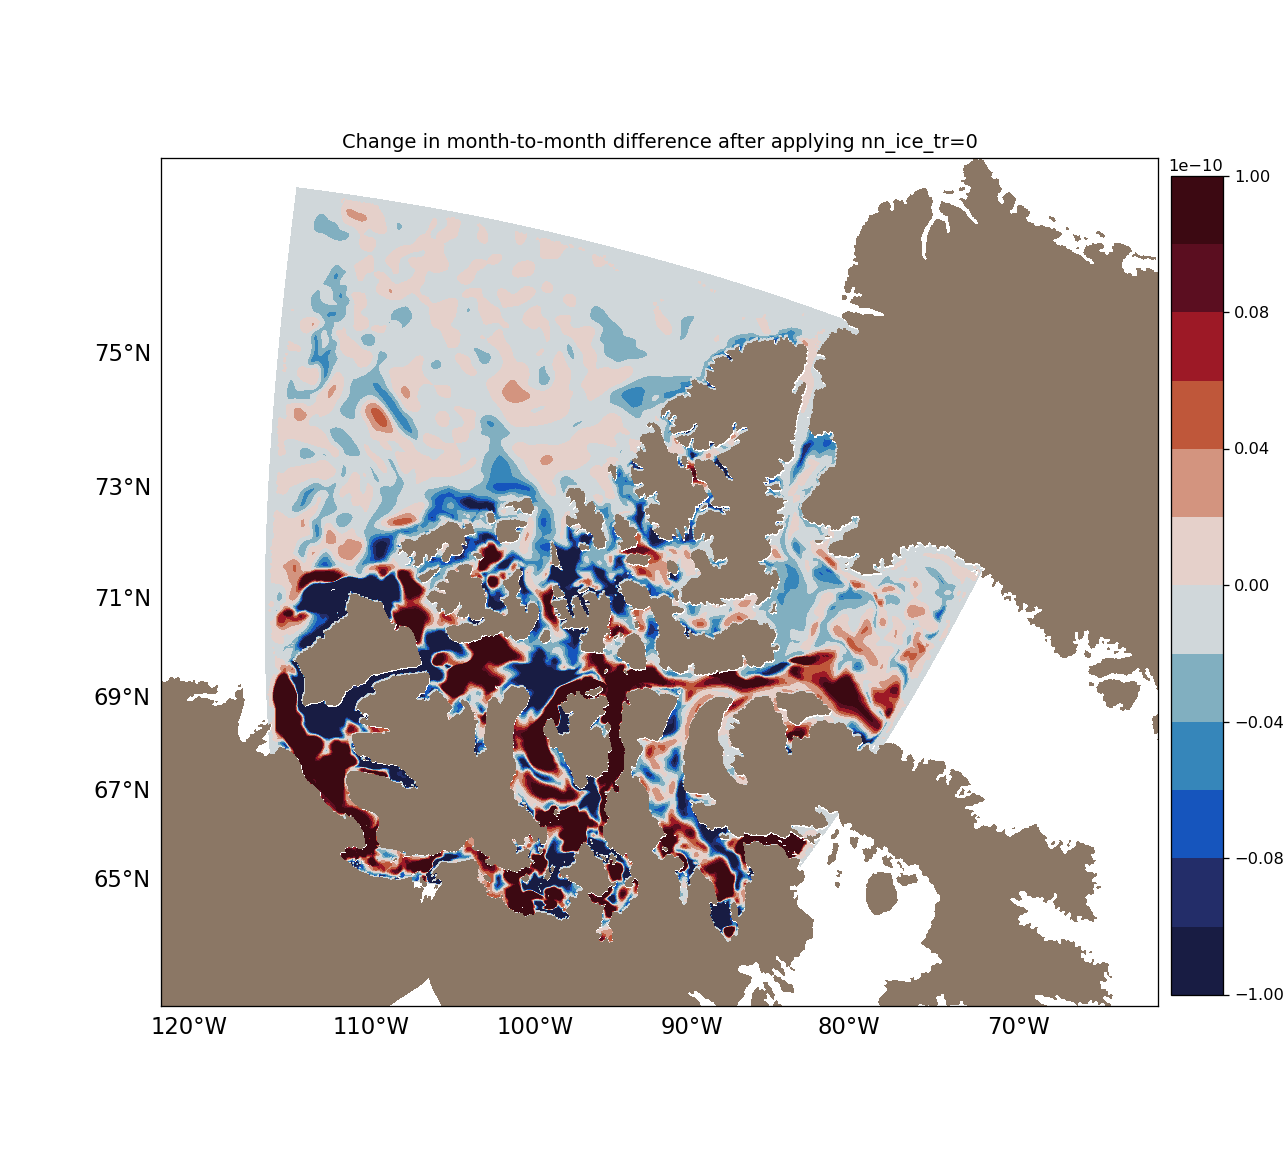

In [41]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

x, y = proj(lons, lats)
colour=cmocean.cm.balance

levels_diff = [-1e-10, -1e-11, -8e-12, -6e-12, -4e-12, -2e-12, 0, 2e-12, 4e-12, 6e-12, 8e-12, 1e-11, 1e-10]
min_v  = -1e-11
max_v  = 1e-11
cbar = proj.contourf(x, y, diff_change[10,0,:,:], levels_diff, vmin=min_v, vmax=max_v, cmap=colour, )
plt.title('Change in month-to-month difference after applying nn_ice_tr=0')
    
fig = gcf()
cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);